# Football Player Data Analysis Over Time: Part 2
Author: Olеksаndr Sоlоvеi (No 126784)
Date: November 22, 2024
Repository: https://github.com/s126784/fcd/

## Project Objectives

Building a data-driven engine to analyze football player trends by combining data from Transfermarkt and arquivo.pt, with a focus on textual and sentiment analysis of historical web content.

 - Implement text analysis on web archive content:
    - Process and analyze text content from arquivo.pt snapshots
    - Extract meaningful patterns and key terms
    - Apply sentiment analysis to understand player perception

 - Enhance feature engineering:
   - Create text-based features from article content
   - Develop temporal features from historical data
   - Generate player interaction and position-based metrics

 - Enable sentiment analysis:
   - Analyze sentiment in historical articles about players
   - Correlate sentiment with player market values

Expected outputs include enriched CSV files with new text features, sentiment scores, and engineered metrics for further analysis.
Previous data collection and web scraping components remain essential foundations.


## Process Flow
1. Load dataframes from Part 1
2. Add text analysis to the data pipeline
3. Implement sentiment analysis on historical articles
4. Generate new features and metrics
5. Save enriched dataframes to CSV files

## Expected Outputs
- Updated player data CSV files with new features and sentiment scores for further analysis

## Methodology

### Data Loading

In [197]:
import os
import urllib.parse
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json

In [198]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/osolovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [199]:
# Text preprocessing setup
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))
tfidf = TfidfVectorizer(ngram_range=(1, 2))
scaler = StandardScaler()

In [200]:
year = 2015
data_orig = pd.read_csv(f'data/portugal_{year}_plus.csv')
data_orig.head()

,#,Player,Age,Market value,Name,Position,search_results
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914
2,5,Fábio Coentrão Left-Back,26.0,20000000,Fábio Coentrão,LB,574364
3,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778
4,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300


In [201]:
#extend information with the next year data

next_year = year + 1
data_next = pd.read_csv(f'data/portugal_{next_year}_plus.csv')
data_next.head()

# Merge the two datasets by Player column (Market value column only)
data = pd.merge(data_orig, data_next[['Player', 'Market value']], on='Player', how='left', suffixes=('', f'_{next_year}'))
data['Delta'] = data[f'Market value_{next_year}'] - data['Market value']
# Remove rows with NaN values
data = data.dropna()
data.head()



,#,Player,Age,Market value,Name,Position,search_results,Market value_2016,Delta
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095,110000000.0,-10000000.0
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914,15000000.0,-5000000.0
3,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778,20000000.0,0.0
4,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300,26000000.0,6000000.0
5,3,Pepe Centre-Back,31.0,15000000,Pepe,CB,2244846,10000000.0,-5000000.0


In [202]:
#get snippets from snapshots
snippets_list = []
for i, row in data.iterrows():
    fname = urllib.parse.quote_plus(row['Player'])
    if (os.path.isfile(f'snapshots/{year}_{fname}.json')):
            with open(f'snapshots/{year}_{fname}.json','r') as f:
                snapshot = f.read()
                arquive_data = json.loads(snapshot)

                # extract snippets from response_items and add them as a new column
                # to the dataframe
                for item in arquive_data['response_items']:
                    snippet_data = {
                        'Player': row['Player'],
                        'title': item.get('title', ''),
                        'url': item.get('originalURL', ''),
                        'snippet': item.get('snippet', '')
                    }
                    snippets_list.append(snippet_data)

    else:
        print(f"Snapshot not found for {row['Player']}")
        continue

snippets_df = pd.DataFrame(snippets_list)
snippets_df.sample(10)

,Player,title,url,snippet
424,Cédric Soares Right-Back,Sporting transfere cédric soares para southamp...,http://www.sapo.pt/noticias/sporting-transfere...,Sporting transfere <em>c&eacute;dric</em> <em>...
36,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo homenageado na Madeira,http://www.lux.iol.pt/nacionais/cristiano-rona...,<em>Cristiano</em> <em>Ronaldo</em> homenagead...
195,William Carvalho Defensive Midfield,Pesquisa por carvalho - Quiosque - AEIOU.pt,http://www.aeiou.pt/quiosque/search?s=carvalho...,desvalorizou a aus&ecirc;ncia de Carrillo na ...
288,Nani Left Winger,“Nani marca um golo” - Seleção Nacional - Desp...,http://www.rtp.pt/noticias/selecao-nacional/na...,&#8220;<em>Nani</em> marca um golo&#8221; - Se...
278,Nani Left Winger,Um upgrade chamado Nani. - Futebol Portugal,http://futebolportugal.clix.pt/um-upgrade-cham...,Um upgrade chamado <em>Nani</em>. - Futebol Po...
169,William Carvalho Defensive Midfield,Revista de Imprensa » Ingleses insistem em Wil...,http://revistadeimprensa.com/desporto/ingleses...,Revista de Imprensa &raquo; Ingleses insistem ...
399,Adrien Silva Central Midfield,Adrien e Samaris falham próxima jornada - Fute...,http://www.rtp.pt/noticias/index.php?article=7...,"jornada Carlos Barros 23 Dez, 2014, 21:19 <em..."
229,Pepe Centre-Back,Etiqueta: Pepe :: Jornal da Região,http://m.jregiao-online.webnode.pt/tags/Pepe/,Etiqueta: <em>Pepe</em> :: Jornal da Regi&atil...
315,André Gomes Central Midfield,Rafa no lugar de André Gomes - Futebol - Corre...,http://www.cmjornal.xl.pt/desporto/futebol/det...,Rafa no lugar de <em>Andr&eacute;</em> <em>Gom...
232,Pepe Centre-Back,Pepe Pillz - Igraiigri.com,http://www.igraiigri.com/igri/Pepe+Pillz,<em>Pepe</em> Pillz - Igraiigri.com Igri &#104...


Tokenization and lemmatization allow for text analysis of historical articles.  The `nltk` library provides tools for these tasks.

In [203]:
# Text preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

snippets_df['snippet_size'] = snippets_df['snippet'].apply(lambda x: len(x))

snippets_df['snippet_cleaned'] = snippets_df['snippet'].apply(preprocess_text)
snippets_df['snippet_cleaned_size'] = snippets_df['snippet_cleaned'].apply(lambda x: len(x))

snippets_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266


In [204]:
# Create and configure TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=100,           # Keep top 100 terms
    ngram_range=(1, 2),        # Include single terms and bigrams
    min_df=2,                  # Remove terms that appear in less than 2 documents
    max_df=0.95               # Remove terms that appear in more than 95% of documents
)

# Fit and transform the cleaned snippets
tfidf_matrix = tfidf.fit_transform(snippets_df['snippet_cleaned'])

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=snippets_df.index
)

# Add key TF-IDF features to original dataframe
snippets_df['unique_terms'] = tfidf_df.astype(bool).sum(axis=1)
snippets_df['avg_tfidf'] = tfidf_df.mean(axis=1)
snippets_df['max_tfidf'] = tfidf_df.max(axis=1)

# Get top terms for each player
def get_top_terms(row, n=5):
    term_scores = [(term, score) for term, score in zip(tfidf.get_feature_names_out(), row) if score > 0]
    return sorted(term_scores, key=lambda x: x[1], reverse=True)[:n]

snippets_df['top_terms'] = [get_top_terms(row) for row in tfidf_matrix.toarray()]

# get size
print(f"Original size: {snippets_df.shape[0]}")
snippets_df.head()

Original size: 450


,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r..."
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557..."
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[]
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323..."
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0...."


In [205]:
# Define market-related term categories in Portuguese
MARKET_TERMS = {
    'performance_positive': [
        'talento', 'talentoso', 'excecional', 'extraordinário', 'brilhante',
        'estrela', 'impressionante', 'excelente', 'qualidade', 'potencial',
        'craque', 'fenômeno', 'gênio', 'habilidoso', 'técnico',
        'decisivo', 'maestro', 'líder', 'capitão'
    ],
    'performance_negative': [
        'fraco', 'erro', 'falha', 'decepcionante', 'irregular',
        'mal', 'frágil', 'inconsistente', 'fracasso', 'problema',
        'péssimo', 'ruim', 'desapontante', 'preocupante'
    ],
    'transfer_interest': [
        'transferência', 'contrato', 'negociação', 'interesse', 'alvo',
        'proposta', 'oferta', 'compra', 'venda', 'mercado',
        'cláusula', 'rescisão', 'emprestar', 'empréstimo', 'milhões'
    ],
    'achievements': [
        'gol', 'golo', 'assistência', 'vitória', 'vencer', 'troféu', 'título',
        'campeão', 'prêmio', 'conquista', 'sucesso', 'taça',
        'medalha', 'classificação', 'líder', 'artilheiro'
    ],
    'injury_risk': [
        'lesão', 'lesionado', 'machucado', 'recuperação', 'hospital',
        'cirurgia', 'médico', 'ausência', 'problema físico', 'dor',
        'departamento médico', 'tratamento', 'fora', 'indisponível'
    ]
}

def analyze_portuguese_market_sentiment(text):
    """
    Analyze Portuguese text for market-related sentiments and terms
    """
    text = str(text).lower()

    # Initialize counters
    counts = {category: 0 for category in MARKET_TERMS.keys()}

    # Count terms in each category
    for category, terms in MARKET_TERMS.items():
        for term in terms:
            counts[category] += len(re.findall(r'\b' + term + r'\b', text))

    # Estimate sentiment (simple approach)
    positive_count = counts['performance_positive'] + counts['achievements']
    negative_count = counts['performance_negative'] + counts['injury_risk']

    # Calculate simple sentiment score (-1 to 1)
    total = positive_count + negative_count
    sentiment = 0 if total == 0 else (positive_count - negative_count) / total

    return {
        **counts,
        'sentiment': sentiment,
        'total_market_terms': sum(counts.values())
    }

# Process snippets
market_sentiments = []
for idx, row in snippets_df.iterrows():
    sentiment_data = analyze_portuguese_market_sentiment(row['snippet_cleaned'])
    market_sentiments.append(sentiment_data)

# Convert to DataFrame
market_sentiment_df = pd.DataFrame(market_sentiments)
aggregated_df = pd.concat([snippets_df, market_sentiment_df], axis=1)
aggregated_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r...",0,0,0,0,0,0.0,0
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557...",0,0,0,0,0,0.0,0
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[],0,0,0,0,0,0.0,0
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323...",0,0,0,0,0,0.0,0
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0....",0,0,0,0,0,0.0,0


In [206]:
aggregated_df.describe()

,snippet_size,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,484.624444,318.097778,12.313333,0.029354,0.535331,0.040000,0.053333,0.068889,0.033333,0.037778,-0.002222,0.233333
std,121.320275,86.271102,5.012417,0.007247,0.152492,0.280312,0.293660,0.343130,0.251941,0.292283,0.323531,0.634038
min,71.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,454.250000,294.250000,9.000000,0.024756,0.432076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,488.500000,323.000000,12.000000,0.029690,0.507303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,523.750000,347.000000,16.000000,0.034527,0.604704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1501.000000,1001.000000,27.000000,0.047626,0.974783,4.000000,2.000000,3.000000,3.000000,3.000000,1.000000,4.000000


In [207]:
if os.path.exists('data/url_content.csv'):
    url_content_df = pd.read_csv('data/url_content.csv')
else:
    url_content_df = pd.DataFrame(columns=['url', 'html_content', 'extracted_text', 'status'])

def load_url_content(url: str):
    """
    Load content from a URL with error handling and rate limiting.

    Args:
        url: The URL to fetch

    Returns:
        HTML content as string or None if failed
    """
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.text
    except Exception as e:
        # print(f"Error fetching URL {url}: {str(e)}")
        return None

# Process URLs in batches
stats = {
    'success': 0,
    'failed': 0,
    'cached': 0
}
for i, row in aggregated_df.iterrows():
    url = row['url']

    # skip if URL is already processed  (strict check)
    if (url_content_df['url'] == url).any():
        stats['cached'] += 1
        continue

    # Load and process URL
    html_content = load_url_content(url)

    if html_content:
        status = 'success'
        stats['success'] += 1
    else:
        html_content = ''
        extracted_text = ''
        status = 'failed'
        stats['failed'] += 1

    # Add to results
    url_content_df = pd.concat([url_content_df, pd.DataFrame({
        'url': [url],
        'html_content': [html_content],
        'extracted_text': [extracted_text],
        'status': [status]
    })], ignore_index=True)
    # print(f"Processed {i+1} URLs")

url_content_df.to_csv('data/url_content.csv', index=False)
print("Stats:", stats)
url_content_df.head()


Stats: {'success': 0, 'failed': 0, 'cached': 450}


,url,html_content,extracted_text,status
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",NaN,success
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",NaN,success
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",NaN,success
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,NaN,success
4,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",NaN,success


In [208]:
#remove pages with status=failed
url_content_df_filtered = url_content_df[url_content_df['status'] == 'success']
len(url_content_df_filtered)


289

In [209]:
import trafilatura

def extract_text_from_html(html_content):
    """
    Extract text content from HTML using Readability.

    Args:
        html_content: The raw HTML content

    Returns:
        Extracted text as string
    """
    return trafilatura.extract(html_content)


# Process HTML content
url_content_df_filtered['extracted_text'] = url_content_df_filtered['html_content'].apply(extract_text_from_html)
url_content_df_filtered.head()



/var/folders/d6/f9l_b01s539_s36ngz7zhl4w0000gn/T/ipykernel_25621/459844062.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_content_df_filtered['extracted_text'] = url_content_df_filtered['html_content'].apply(extract_text_from_html)


,url,html_content,extracted_text,status
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success
4,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success


In [210]:

def extract_meta_from_html(html_content):
    """
    Extract metadata from HTML using Readability.

    Args:
        html_content: The raw HTML content

    Returns:
        Extracted metadata as dictionary
    """
    metadata =  trafilatura.extract_metadata(html_content)
    return {
        # 'title': metadata.title if metadata else None,
        # 'author': metadata.author if metadata else None,
        'categories': metadata.categories if metadata else None,
        'tags': metadata.tags if metadata else None,
    }

metadata = url_content_df_filtered['html_content'].apply(extract_meta_from_html)
metadata_df = pd.DataFrame(metadata.tolist())

#show distribution of categories
metadata_df.head()


,categories,tags
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]


In [211]:
print(f"Total URLs: {len(metadata_df)}")
metadata_df['categories'].explode().value_counts()

Total URLs: 289


categories
Desporto           10
Sporting            4
undefined           3
 Clube Portugal     3
Uncategorized       1
Jogos               1
 Sporting           1
Cultura-Ípsilon     1
Name: count, dtype: int64

In [212]:
# remove pages with empty extracted_text
url_content_df_filtered = url_content_df_filtered[url_content_df_filtered['extracted_text'] != '']

In [213]:
#apply sentiment analysis to extracted text
market_sentiments = []
for idx, row in url_content_df_filtered.iterrows():
    sentiment_data = analyze_portuguese_market_sentiment(row['extracted_text'])
    market_sentiments.append(sentiment_data)

# Convert to DataFrame

url_content_plus_sentiment_df = pd.concat([url_content_df_filtered, pd.DataFrame(market_sentiments)], axis=1)
url_content_plus_sentiment_df.head()

,url,html_content,extracted_text,status,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success,42.0,5.0,68.0,397.0,36.0,0.829167,548.0
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success,1.0,0.0,1.0,7.0,1.0,0.777778,10.0
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success,0.0,0.0,9.0,6.0,0.0,1.000000,15.0


In [214]:
# Merge the two datasets by URL column
aggregated_df = pd.merge(snippets_df, url_content_plus_sentiment_df[['url', 'sentiment', 'total_market_terms']], on='url', how='left')
aggregated_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms,sentiment,total_market_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r...",0.829167,548.0
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557...",0.000000,0.0
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[],0.777778,10.0
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323...",0.000000,0.0
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0....",0.000000,2.0


In [215]:
# group by player and calculate average sentiment and total market terms
player_sentiment = aggregated_df.groupby('Player').agg({
    'sentiment': 'sum',
    'total_market_terms': 'sum'
}).reset_index()

player_sentiment.head()

,Player,sentiment,total_market_terms
0,Adrien Silva Central Midfield,9.438176,747.0
1,André Gomes Central Midfield,11.200000,86.0
2,Cristiano Ronaldo Centre-Forward,10.106944,619.0
3,Cédric Soares Right-Back,8.675676,182.0
4,João Moutinho Central Midfield,-0.033333,69.0


In [216]:
# Merge sentiment data with original dataset
final_data = pd.merge(data, player_sentiment, on='Player', how='left')
final_data.head()


,#,Player,Age,Market value,Name,Position,search_results,Market value_2016,Delta,sentiment,total_market_terms
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095,110000000.0,-10000000.0,10.106944,619.0
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914,15000000.0,-5000000.0,13.523810,73.0
2,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778,20000000.0,0.0,-0.033333,69.0
3,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300,26000000.0,6000000.0,5.166667,96.0
4,3,Pepe Centre-Back,31.0,15000000,Pepe,CB,2244846,10000000.0,-5000000.0,2.666667,13.0


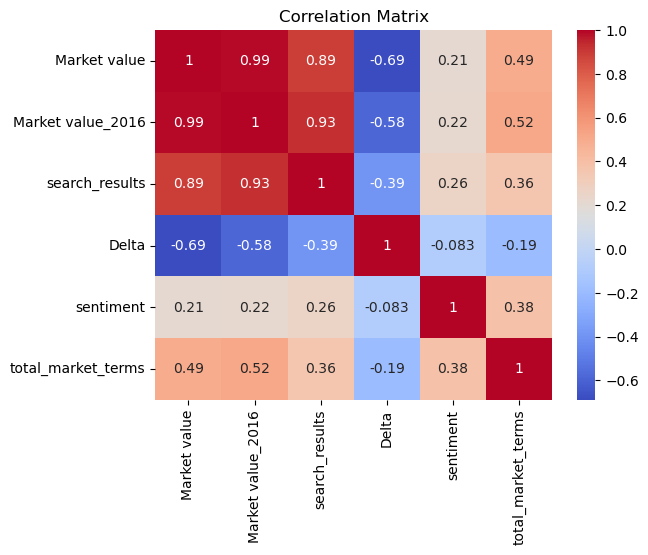

In [217]:
#show correlation matrix between 'Market Value', 'Market value_2016', 'Delta', 'sentiment', 'sentiment_x', 'sentiment_y', total_market_terms', 'total_market_terms_x', 'total_market_terms_y'

correlation_matrix = final_data[['Market value', f'Market value_{next_year}', 'search_results', 'Delta', 'sentiment', 'total_market_terms']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [218]:
from tqdm import tqdm
import torch
# using more advanced sentiment analysis
# %pip install transformers torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load pre-trained sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Load pre-trained Portuguese BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Get texts from DataFrame, removing any empty or NaN values
texts = url_content_df_filtered['extracted_text'].tolist()
print(f"Found {len(texts)} texts to analyze")

# Initialize list to store results
results = []

# Set batch size for processing
batch_size = 8

# Process texts in batches with progress bar
for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing sentiments"):
    # Get current batch of texts
    batch_texts = texts[i:i + batch_size]

    # Skip empty texts in batch
    batch_texts = [text for text in batch_texts if isinstance(text, str) and text.strip()]
    if not batch_texts:
        continue

    # Tokenize texts
    inputs = tokenizer(
        batch_texts,
        truncation=True,
        max_length=512,
        padding=True,
        return_tensors="pt"
    )

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1)
        scores = scores.numpy()

    # Process results for each text in batch
    for j, score in enumerate(scores):
        results.append({
            'url': url_content_df_filtered['url'].iloc[i + j],
            'text': batch_texts[j],
            'positive': float(score[1]),
            'negative': float(score[0]),
            'sentiment': 'positive' if score[1] > score[0] else 'negative',
            'confidence': float(max(score))
        })

# Create DataFrame with results
results_df = pd.DataFrame(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 282 texts to analyze


Analyzing sentiments: 100%|██████████| 36/36 [00:27<00:00,  1.30it/s]


In [219]:
results_df.sample(10)

,url,text,positive,negative,sentiment,confidence
111,http://www.coolaspel.se/spel/Pepe+Pillz,Spel utan reklam\nLogga in\nMahjong\nArkad\n�v...,0.458850,0.541150,negative,0.541150
110,http://www.spilstedet.dk/spil/Pepe+Pillz,SÃG!,0.414001,0.585999,negative,0.585999
125,http://www.benoynarim.com/oyunlar/Pepe+Le+Pew,Pepe Le Pew\nYetenek Oyunları kategorisinden b...,0.429215,0.570785,negative,0.570785
70,http://opiniaodesconcertante.blogs.sapo.pt/120...,"E cada vez mais modesto, pelos vistos.\nDe Joã...",0.448168,0.551832,negative,0.551832
115,http://www.igraiigri.com/igri/Pepe+Pillz,"Pepe Pillz\nБлагодаря,че ни посетихте. Надявам...",0.454523,0.545477,negative,0.545477
72,https://www.youtube.com/embed/y5JSPxyBS9w,Ocorreu um erro.\nExperimente ver este vídeo e...,0.411461,0.588539,negative,0.588539
73,http://blogs.sapo.pt/commentsrss.bml?blog=bigf...,Equipas de reforÃ§o vÃ£o ser criadas entre 1 d...,0.394841,0.605159,negative,0.605159
263,http://rr.sapo.pt/bolabranca_detalhe.aspx?fid=...,Em vésperas da estreia de Rúben Amorim como tr...,0.481526,0.518474,negative,0.518474
113,http://m.jregiao-online.webnode.pt/tags/Pepe/,"JORNAL DA REGIÃO\nPor favor, aguarde...\nEtiqu...",0.439460,0.560540,negative,0.560540
136,http://nacaofutebol.webnode.pt/album/galeria-d...,Luciano Pinheiro\nEdificando Vidas\nSobre Nós\...,0.416203,0.583797,negative,0.583797


In [ ]:
# Merge results_df sentiment data with original dataset
aggregated_df = pd.merge(snippets_df, results_df[['positive', 'negative', 'sentiment', 'confidence', 'url']], on='url', how='inner')
aggregated_df['positive_count'] = (aggregated_df['positive'] > 0.48).astype(int)
aggregated_df['negative_count'] = (aggregated_df['negative'] > 0.52).astype(int)
aggregated_df.sample(10)

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms,positive,negative,sentiment,confidence,positive_count,negative_count
117,João Moutinho Central Midfield,"""Moutinho não joga nada de especial"" - Renascença",http://rr.sapo.pt/bolabranca_detalhe.aspx?fid=...,principado durante 19 temporadas) fez graves ...,529,principado durante 19 temporadas fez graf cr i...,350,13,0.032038,0.493709,"[(quot, 0.4937093209782677), (moutinho, 0.4633...",0.394841,0.605159,negative,0.605159,0,1
226,Nani Left Winger,"""nani.jpg"" de ammalmeida33 no SAPO Fotos",http://fotos.sapo.pt/ammalmeida33/fotos/?uid=4...,&quot;<em>nani</em>.jpg&quot; de ammalmeida33 ...,484,quot nani quot ammalmeida33 sapo fotos sapo fo...,281,7,0.017618,0.913385,"[(quot, 0.9133852126280402), (nani, 0.32732138...",0.415892,0.584108,negative,0.584108,0,1
257,André Gomes Central Midfield,Anamneses - PÚBLICO,http://www.publico.pt/culturaipsilon/noticia/a...,Oliveira 08/05/2015 - 02:44 Vozes Interiores ...,526,oliveira vozes interiores parte mem oacute ria...,314,15,0.032465,0.449161,"[(eacute gomes, 0.4491606777065492), (gomes, 0...",0.451091,0.548909,negative,0.548909,1,0
27,Cristiano Ronaldo Centre-Forward,CR7 by Cristiano Ronaldo - Notícias - Vogue Po...,http://www.vogue.xl.pt/moda/noticias/detalhe/c...,CR7 by <em>Cristiano</em> <em>Ronaldo</em> - N...,551,cr7 by cristiano ronaldo not iacute cia vogue ...,358,11,0.027308,0.569233,"[(cristiano, 0.5692327734478304), (ronaldo, 0....",0.433171,0.566829,negative,0.566829,0,1
213,Nani Left Winger,Palavra-chave: Nani Azevedo :: Luciano Pinheiro,http://m.pastor-luciano.webnode.pt/tags/Nani%2...,Palavra-chave: <em>Nani</em> Azevedo :: Lucian...,367,nani azevedo luciano pinheiro luciano pinheiro...,178,2,0.012508,0.955356,"[(nani, 0.955355578421425), (http, 0.295458489...",0.417213,0.582787,negative,0.582787,0,1
270,Adrien Silva Central Midfield,Fotos: Adrien Silva diverte-se em família no Z...,http://www.lux.iol.pt/nacional/famosos/fotos-a...,Fotos: <em>Adrien</em> <em>Silva</em> diverte-...,509,fotos adrien silva fam iacute lia zoomarine as...,289,4,0.018553,0.623273,"[(adrien, 0.6232732291355799), (silva, 0.58111...",0.440293,0.559707,negative,0.559707,0,1
102,João Moutinho Central Midfield,adidas adipower Predator - João Moutinho e Jav...,https://www.youtube.com/embed/y5JSPxyBS9w,adidas adipower Predator - <em>Jo&atilde;o</em...,128,adidas adipower predator jo atilde moutinho ja...,70,5,0.021832,0.514493,"[(atilde moutinho, 0.5144932756396874), (mouti...",0.411461,0.588539,negative,0.588539,0,1
311,Cédric Soares Right-Back,_Briosapress_: Cédric,http://briosapress.blogspot.pt/search/label/C%...,e <em>C&eacute;dric</em> desejados Tudo por D...,522,c eacute dric desejados tudo david sim atilde ...,317,7,0.022288,0.604481,"[(dric, 0.6044809622609326), (eacute dric, 0.6...",0.508405,0.491595,positive,0.508405,1,0
293,Cédric Soares Right-Back,Noticias ao Minuto - Cédric Soares em destaque...,http://www.noticiasaominuto.com/desporto/47974...,Noticias ao Minuto - <em>C&eacute;dric</em> <e...,503,noticias minuto c eacute dric soares destaque ...,322,16,0.034530,0.414940,"[(dric soares, 0.4149404410744383), (dric, 0.4...",0.518703,0.481297,positive,0.518703,1,0
193,Pepe Centre-Back,Pepe Le Pew - Benoynarim.com,http://www.benoynarim.com/oyunlar/Pepe+Le+Pew,<em>Pepe</em> Le Pew - Benoynarim.com Oyunlar ...,484,pepe le pew oyunlar macera oyunlar 305 u ccedi...,365,8,0.026070,0.464552,"[(le pew, 0.46455247634541474), (pepe le, 0.46...",0.470911,0.529089,negative,0.529089,1,0


In [240]:


# group by player and calculate average sentiment and total market terms
player_sentiment = aggregated_df.groupby('Player').agg({
    'positive': 'mean',
    'negative': 'mean',
    'positive_count': 'sum',
    'negative_count': 'sum',
}).reset_index()


final_data = pd.merge(data, player_sentiment, on='Player', how='left')
final_data.head()


,#,Player,Age,Market value,Name,Position,search_results,Market value_2016,Delta,positive,negative,positive_count,negative_count
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095,110000000.0,-10000000.0,0.435718,0.564282,14,31
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914,15000000.0,-5000000.0,0.448884,0.551116,16,25
2,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778,20000000.0,0.0,0.443276,0.556724,14,18
3,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300,26000000.0,6000000.0,0.445600,0.554400,13,15
4,3,Pepe Centre-Back,31.0,15000000,Pepe,CB,2244846,10000000.0,-5000000.0,0.426698,0.573302,13,35


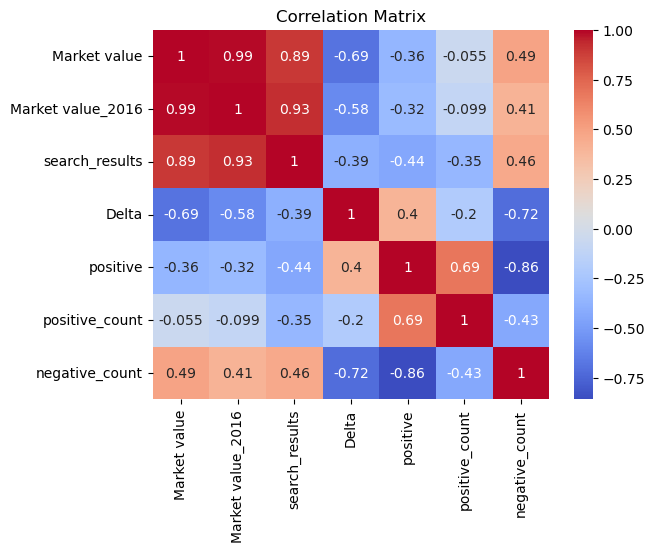

In [241]:
# show correlation matrix between 'Market Value', 'Market value_2016', 'Delta', 'negative'

correlation_matrix = final_data[['Market value', f'Market value_{next_year}', 'search_results', 'Delta', 'positive', 'positive_count','negative_count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Future Improvements

 - Implement player clustering based on text features
 - Develop advanced time series modeling for player trends
 - Apply machine learning for value prediction

## Conclusions

The project successfully implemented text analysis and sentiment analysis on historical web content. The resulting dataframes contain enriched features and sentiment scores for further analysis.

## References

 - Sozen, Y. (2023). Predicting Football Players Market Value Using Machine Learning
 - Transfermarkt Documentation
 - Arquivo.pt API Documentation